In [1]:
# Using the WTI dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importing the Decompositions and approximated sets

#importing the original data
crude =  pd.read_csv('crude.csv')
crude['Date'] = pd.to_datetime(crude['Date'], format='%Y-%m-%d')
crude.set_index(crude['Date'], inplace=True)
crude.drop('Date', axis=1, inplace=True)
crude = crude['2007-02-01':'2015-10-21']
crude.dropna(inplace=True)

#includes the decompositions of level 1-5
decomp= pd.read_csv('Decomp.csv')  

#only importing the approximation of level 5
approx = pd.read_csv('Approx.csv')
approx = approx.transpose().reset_index()
approx = approx[3]
approx = pd.DataFrame(approx.values,columns=['A5'])

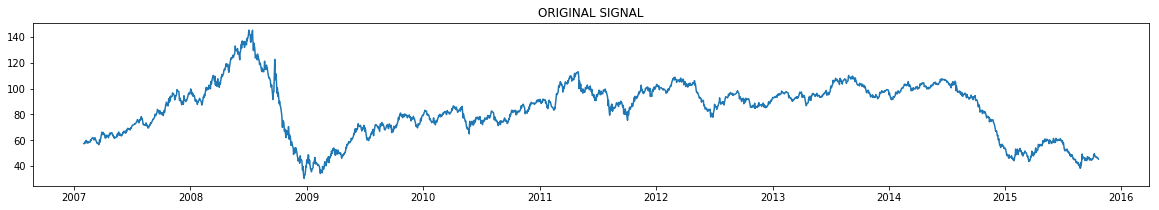

In [3]:
plt.figure(figsize=(20,3))
plt.plot(crude.index, crude.demand)
plt.title('ORIGINAL SIGNAL')
plt.show()

In [4]:
# for i in decomp.columns:
#     plt.figure(figsize=(20,1))
#     plt.plot(decomp[i])
#     plt.xlabel('Sample No')

# # plt.title('DETAILED SIGNAL')
# plt.figure(figsize=(20,1))
# plt.plot(approx.values)
# plt.show()

In [5]:
# Importing some more libraries
import tensorflow as tf
from IPython.display import clear_output

In [6]:
# Defining the Morlet Wavelet Function
def Morlet(z):
    return tf.multiply(tf.cos(tf.multiply(tf.constant(1.75), z)),tf.exp(tf.multiply(tf.pow(z,2), tf.constant(-0.5))))

# Defining the Mexican Hat Wavelet Function
def Mexican(z):
    return tf.multiply(tf.subtract(tf.constant(1.0), tf.pow(z,2)), tf.exp(tf.multiply(tf.constant(-0.5), tf.pow(z,2))))

In [7]:
def new_weights(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=1, seed=3),name = name)

In [8]:
# def Predictor():

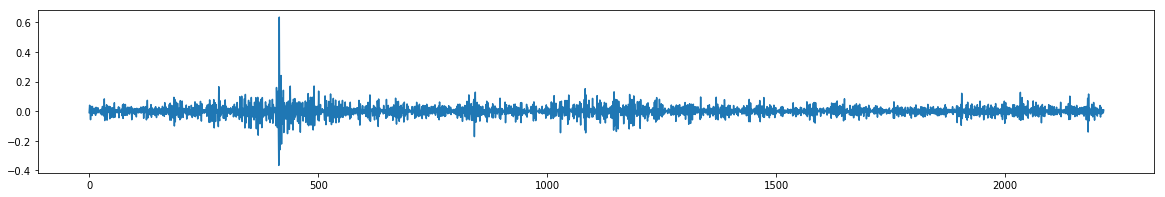

In [9]:
X_train = decomp.copy()
X_train['A5'] = approx.values
X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_train_norm = X_train_norm.values
X_train_norm = X_train_norm.T[0].reshape([X_train.shape[0],1])
plt.figure(figsize=(20,3))
plt.plot(X_train_norm)
plt.show()

In [10]:
n_features = X_train_norm.shape[1]
n_hidden = 10                
n_class = 1
lr = 0.005        #Learning rate
alpha = 1

In [11]:
# Input and target Placeholders
x = tf.placeholder(tf.float32, [None, n_features], name = 'X_label')      # n X 6
y = tf.placeholder(tf.float32, [None, n_class], name = 'y_label')

In [12]:
#Defining the various weights in Tesorflow graph

W_inphid = new_weights([n_hidden, n_features], 'wij')   # 10 X 1
W_trans = new_weights([n_hidden, 1], 'bj')              # 10 X 1
W_dilat = new_weights([n_hidden, 1],'aj')               # 10 X 1
W_hidout = new_weights([n_class, n_hidden], 'cj')       # 1 X 10
W_rec = new_weights([n_class, n_hidden], 'vj')          # 1 X 10

biases = tf.Variable(tf.constant(0.05, shape=[1]))

In [13]:
# Initial Values of recurrent part
u = tf.random_normal(shape=[10,1], mean=0,stddev=0.3,seed=3)     # 10 X 1
# u = tf.zeros(shape=[10,1])     # 10 X 1

# Net input to Hidden Layer
net_hidd = tf.add(tf.divide(tf.subtract(tf.matmul(W_inphid, tf.transpose(x)), W_trans),W_dilat), tf.multiply(tf.transpose(W_rec), u))   # 10 X ?

# Output of Hidden Layer
out_hidd = Morlet((net_hidd)) + biases

# Final Output
out = tf.matmul(W_hidout,out_hidd)   # 1 X ?

# Cost
cost = tf.reduce_mean(tf.square(out-y))

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)

In [14]:
# Stochastic Time Effective function

In [15]:
x_train = np.roll(X_train_norm, 2)
# Y_train = (Y_train - min(approx.values))/(max(approx.values) - min(approx.values))
x_train = x_train.reshape(2216)
Y_train = X_train_norm
# x_train = (X_train - min(approx.values))/(max(approx.values) - min(approx.values))
Y_train = Y_train.reshape(2216)

In [16]:
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
batch_size = 3
n_examp = X_train.shape[0]
x_train = tf.data.Dataset.from_tensor_slices(x_train)
Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
# zip the two datasets together
dcomb = tf.data.Dataset.zip((x_train, Y_train)).batch(batch_size)
iterator = dcomb.make_initializable_iterator()
# extract an element
next_element = iterator.get_next()

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
def optimize(num_iterations):
    costy=[]
    sess.run(iterator.initializer)
    print('Epoch :', end='')
    for j in range(num_iterations):
        print(j, end=' ')
        i=1
        sess.run(iterator.initializer)
        tot_cost = 0
        while(i):
            try:
                val = sess.run(next_element)
                val = np.array(val)
                feed_dict_train = {x:val[0].reshape(batch_size,1), y:val[1].reshape(batch_size,1)}
                _, cos = sess.run([optimizer, cost] ,feed_dict=feed_dict_train)
                tot_cost += cos
            except:
                i=0
                continue
        costy.append(tot_cost)
#         clear_output()
        
    # Predicting the values
    feed_dict_train = {x:X_train_norm}
    pred = sess.run(out, feed_dict=feed_dict_train)
        
    return costy, pred

Epoch :0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 Final Cost =  3.362235512555344


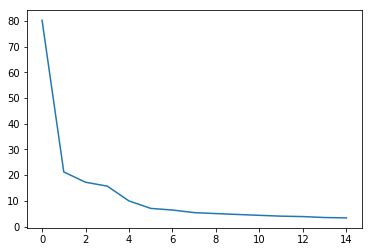

In [19]:
costy, pred = optimize(num_iterations=15)
print('Final Cost = ', costy[-1])
plt.plot(costy)
plt.show()

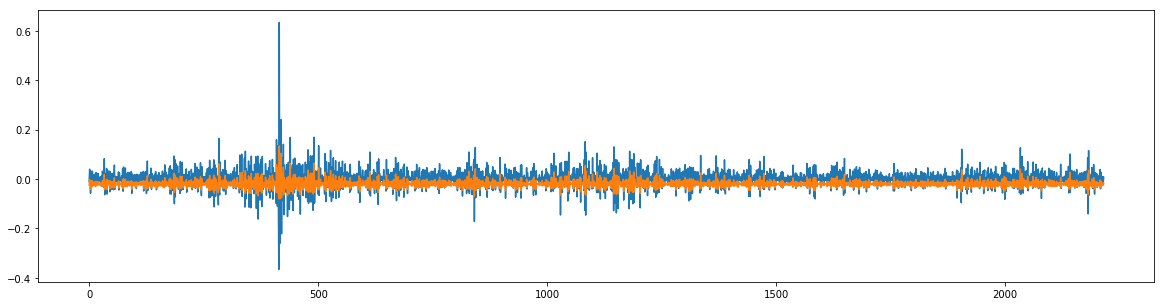

In [20]:
plt.figure(figsize=[20,5])
plt.plot(X_train_norm)
plt.plot(pred[0])
plt.show()